In [1]:
import warnings

warnings.filterwarnings("ignore")

In [ ]:
import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [6]:
train_data = pd.read_csv("./data/train.txt", header=None, delimiter=";")
test_data = pd.read_csv("./data/test.txt", header=None, delimiter=";")

In [7]:
train_data.head()

,0,1
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [8]:
test_data.head()

,0,1
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [10]:
train_data.rename(columns={0: "text", 1: "sentiment_class"}, inplace=True)
test_data.rename(columns={0: "text", 1: "sentiment_class"}, inplace=True)

In [11]:
train_data.head()

,text,sentiment_class
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [13]:
train_data.shape, test_data.shape

((16000, 2), (2000, 2))

In [14]:
train_data.sentiment_class.value_counts()

sentiment_class
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [15]:
test_data.sentiment_class.value_counts()

sentiment_class
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

In [17]:
set(train_data.sentiment_class.unique()).difference(set(test_data.sentiment_class.unique()))

set()

In [19]:
# !python -m spacy download en_core_web_md -q

In [20]:
en_dict = spacy.load("en_core_web_md")

In [23]:
doc = en_dict("hello darkness my old friend")
doc

hello darkness my old friend

In [25]:
doc[0].is_stop

False

In [28]:
tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]
tokens

['hello', 'darkness', 'old', 'friend']

In [29]:
" ".join(tokens)

'hello darkness old friend'

In [30]:
def preprocess_text(text, wrapper=en_dict):
    doc = wrapper(text)
    
    return " ".join( [token.lemma_.lower().strip() for token in doc if not token.is_stop] )


In [31]:
for d in (train_data, test_data):
    d["preprocessed_text"] = d.text.apply(lambda text: preprocess_text(text))

In [32]:
train_data.head()

,text,sentiment_class,preprocessed_text
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


### 1st model - fnn

In [33]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words="english")

In [35]:
train_tfidf = tfidf.fit_transform(train_data.preprocessed_text)
test_tfidf = tfidf.transform(test_data.preprocessed_text)

In [36]:
train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 112810 stored elements and shape (16000, 5587)>

In [37]:
X_train = train_tfidf.toarray()
X_test  = test_tfidf.toarray()

In [40]:
X_train[0, :20]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [41]:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train_data.sentiment_class)
y_test  = encoder.transform(test_data.sentiment_class)

In [42]:
y_train.shape

(16000,)

In [44]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5])

In [46]:
class_balancing = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
class_balancing

array([1.23513973, 1.37669936, 0.49732687, 2.04498978, 0.57151022,
       4.66200466])

In [47]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_train
)

In [50]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [51]:
y_train.shape, y_val.shape

((12800, 6), (3200, 6))

In [52]:
y_train[0]

array([0., 0., 0., 0., 1., 0.])

In [57]:
4096/2/2/2/2/2

128.0

In [58]:
N_CLASSES = 6

In [61]:
model = Sequential()

model.add(
    Dense(
        512, 
        activation="selu",
        kernel_initializer="lecun_normal", 
        input_shape=(X_train.shape[1], ), 
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

model.add(
    Dense(
        256, 
        activation="selu",
        kernel_initializer="lecun_normal", 
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

model.add(
    Dense(
        128, 
        activation="selu",
        kernel_initializer="lecun_normal", 
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

model.add(
    Dense(
        64, 
        activation="selu",
        kernel_initializer="lecun_normal", 
    )
)

model.add(
    Dense(
        N_CLASSES, 
        activation="softmax",
    )
)

In [63]:
model.layers

[<Dense name=dense_10, built=True>,
 <Dense name=dense_11, built=True>,
 <Dense name=dense_12, built=True>,
 <Dense name=dense_13, built=True>,
 <Dense name=dense_14, built=True>]

In [65]:
model.layers[-1].bias.assign(class_balancing)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

In [66]:
model.compile(
    optimizer="Adam",  
    loss = tf.losses.categorical_crossentropy,  
    metrics = ["accuracy"])  

In [67]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 512)            │     2,861,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,033,926 (11.57 MB)

 Trainable params: 3,033,926 (11.57 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
def step_dacay(epoch):
    start_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0

    return start_lr * math.pow(drop, math.floor( (1 + epoch) / epochs_drop ))

In [70]:
lr_scheduler = LearningRateScheduler(step_dacay)

In [71]:
early_stopping = EarlyStopping(monitor="val_loss", restore_best_weights=True, patience=3)

In [72]:
N_EPOCHS = 10
BATCH_SIZE = 128

In [73]:
%%time
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=N_EPOCHS, 
    batch_size=BATCH_SIZE, 
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.4273 - loss: 5.6018 - val_accuracy: 0.7972 - val_loss: 1.4871 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.8405 - loss: 1.2372 - val_accuracy: 0.8056 - val_loss: 1.1193 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.8778 - loss: 0.9080 - val_accuracy: 0.8259 - val_loss: 1.0324 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9012 - loss: 0.8060 - val_accuracy: 0.8172 - val_loss: 1.0568 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9046 - loss: 0.7862 - val_accuracy: 0.8109 - val_loss: 1.0137 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9178 - loss: 0.7043 - val_accuracy: 0.8294 - val_loss: 0.9500 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9330 - loss: 0.

In [74]:
loss, val_loss = history.history["loss"], history.history["val_loss"]

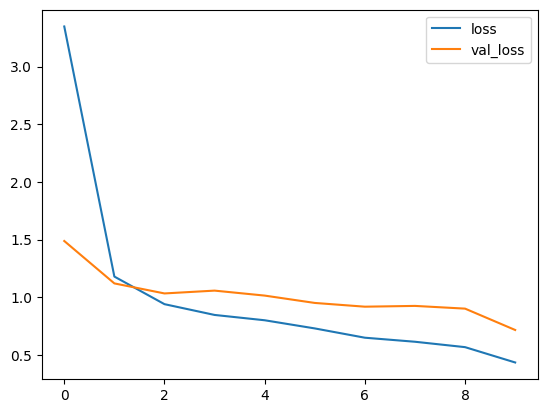

In [76]:
plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.show()

In [77]:
preds = model.predict(X_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


In [81]:
preds.shape

(2000, 6)

In [78]:
labels = preds.argmax(axis=1)

In [82]:
labels.shape

(2000,)

In [80]:
labels

array([4, 0, 2, ..., 2, 2, 1])

In [84]:
y_test.argmax(axis=1)

array([4, 0, 2, ..., 2, 2, 1])

In [85]:
print(classification_report(y_test.argmax(axis=1), labels))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       275
           1       0.81      0.83      0.82       224
           2       0.87      0.89      0.88       695
           3       0.71      0.74      0.72       159
           4       0.90      0.87      0.89       581
           5       0.75      0.61      0.67        66

    accuracy                           0.85      2000
   macro avg       0.82      0.80      0.81      2000
weighted avg       0.85      0.85      0.85      2000



In [86]:
print(confusion_matrix(y_test.argmax(axis=1), labels))

[[231   9  13   1  21   0]
 [ 10 187   7   1  14   5]
 [  8   6 622  38  14   7]
 [  1   2  32 117   6   1]
 [ 21  14  34   5 507   0]
 [  2  12   9   2   1  40]]


In [87]:
print(accuracy_score(y_test.argmax(axis=1), labels))

0.852


In [88]:
model.save("./models/fnn_model.keras")

In [89]:
loaded_model = load_model("./models/fnn_model.keras")

In [90]:
sample = "I hope that the new matrix movie can be so great as the last ones"

In [95]:
preprocess_sample = tfidf.transform( [preprocess_text(sample)] ).toarray()
preprocess_sample

array([[0., 0., 0., ..., 0., 0., 0.]])

In [100]:
pred = loaded_model.predict(preprocess_sample).argmax(axis=1)

class_name = encoder.inverse_transform( pred )
class_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


array(['joy'], dtype=object)